# Analysing acessibility
cite: Morelli, A. B., & Cunha, A. L. (2021). Assessing vulnerabilities in transport networks: a graph-theoretic approach. TRANSPORTES, 29(1), 161–172.
https://doi.org/10.14295/transportes.v29i1.2250

In [1]:
import osmnx as ox
import geopandas as gpd
from tools import network_analysis as stats, accessibility as acc

In [2]:
# for accessibility analysis, we need more than graph data

# São Carlos Census Tracts:
tracts = gpd.read_file('test_data/MonteAlto-Tracts.gpkg')
# take only urban sectors
tracts = tracts[tracts['TIPO']=='URBANO']
tracts = tracts.to_crs('epsg:4326')

# São Carlos Census Points Of Interest:
pois = gpd.read_file('test_data/MonteAlto-Pois.gpkg')
# we only keep info on educational facilities:
pois = pois[pois['educação']>0]
pois = pois.to_crs('epsg:4326')

C:\Users\Andre\anaconda3\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


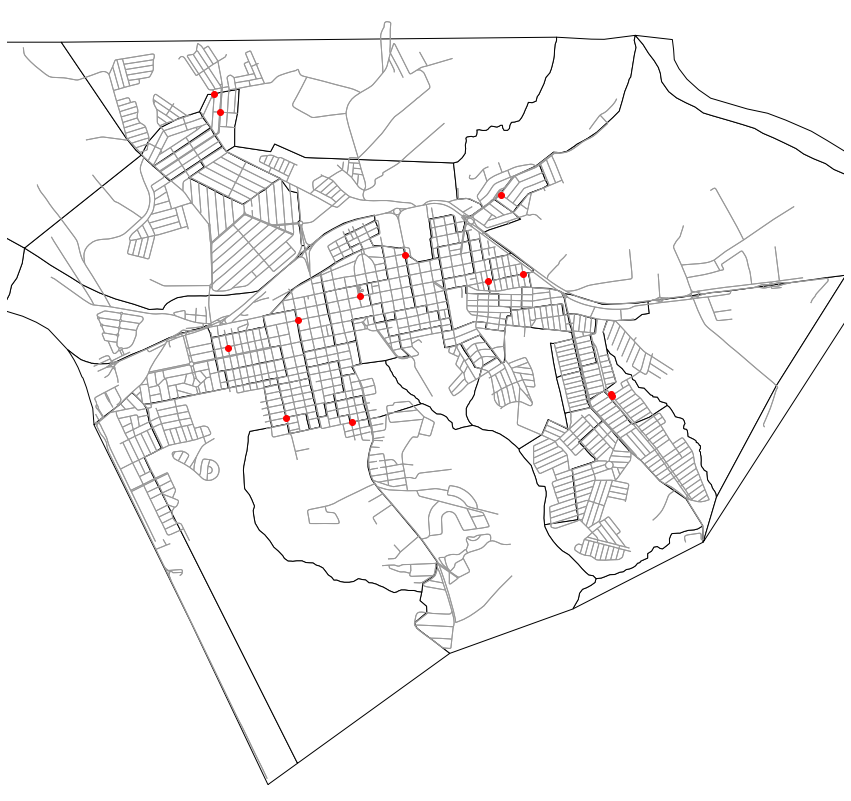

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

In [3]:
#Get graph from census geometry:
G = ox.graph_from_polygon(tracts.unary_union, network_type='walk')
ax = tracts.plot(color='w',edgecolor='k',zorder=0,figsize=(15,15))
ax = pois.plot(color='r',zorder=3,ax=ax)
ox.plot_graph(G,ax=ax,node_size=0)

<AxesSubplot:>

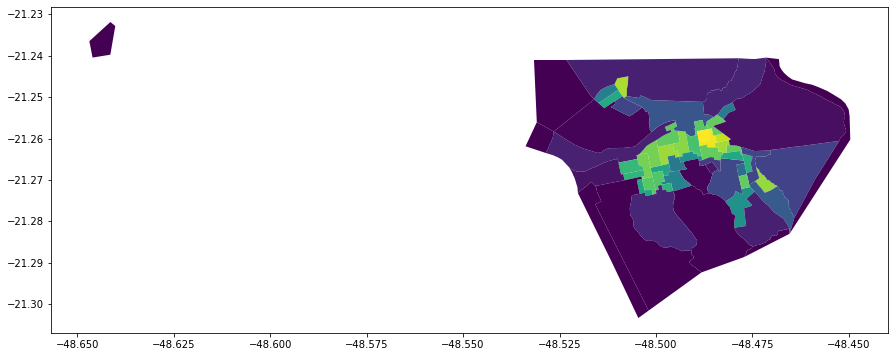

In [4]:
# calculate accessibility for each census tract
accessibility = acc.calc_tract_accessibility(tracts,pois,G,
                                             # weight the destinations by number of 
                                             # education facilities on the POI
                                             pois_weight_column='educação',
                                             # use cumulative gaussian as funciton
                                             func=acc.acc_cumulative_gaussian,
                                             # set function param to 400m walk dist:
                                             func_kws={'t':400})
#set it as column in gdf
tracts['accessibility']=accessibility.values()
tracts.plot(column='accessibility',figsize=(15,15))

In [5]:
# calculate accessibility load for each edge on the graph
G_load = acc.calc_accessibility_load(tracts,pois,G,
                                     # weight the destinations by number of 
                                     # education facilities on the POI
                                     pois_weight_column='educação',
                                     # use cumulative gaussian as funciton
                                     func=acc.acc_cumulative_gaussian,
                                     # set function param to 400m walk dist:
                                     func_kws={'t':400}, track_progress=True)
edges = ox.graph_to_gdfs(G_load,nodes=False)

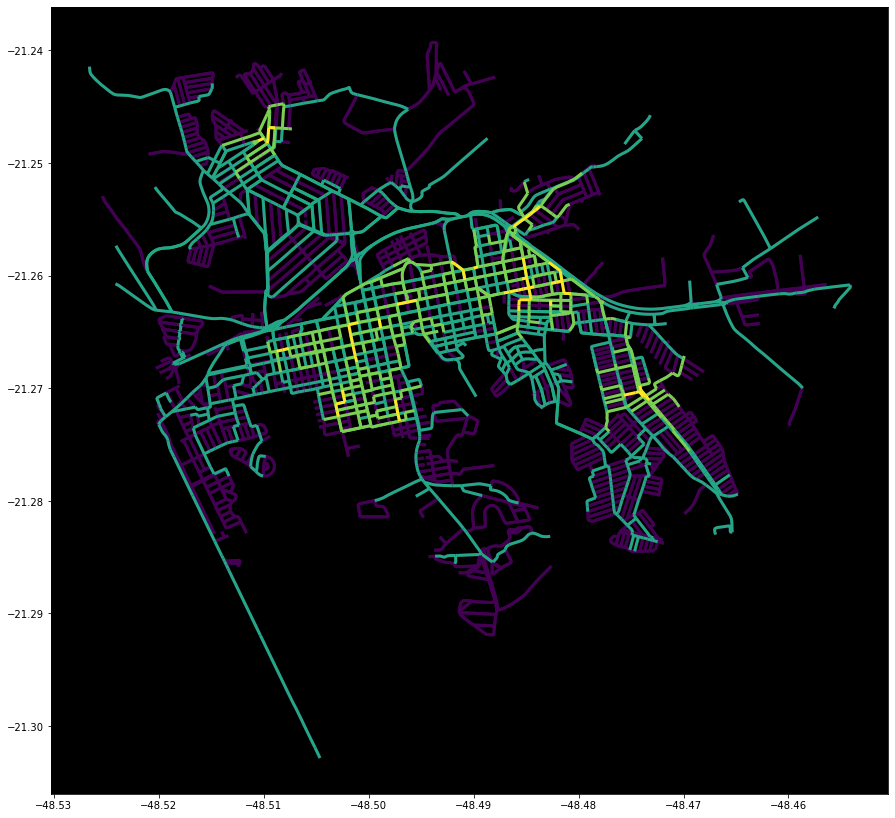

In [6]:
# plot results
edges = edges.sort_values('load')
ax=edges.plot(column='load',scheme='percentiles',#Needs mapclassify
               cmap='viridis',figsize=(15,15), linewidth=3,k=10)
ax.set_facecolor('k')

In [7]:
# generating a random pois file:
from shapely.geometry import Point
pts = acc.random_points_in_polygon(15,tracts.unary_union,seed=42)
pts = [Point(x,y) for x,y in zip(pts[0],pts[1])]
pois = gpd.GeoDataFrame(geometry=pts,crs=tracts.crs)

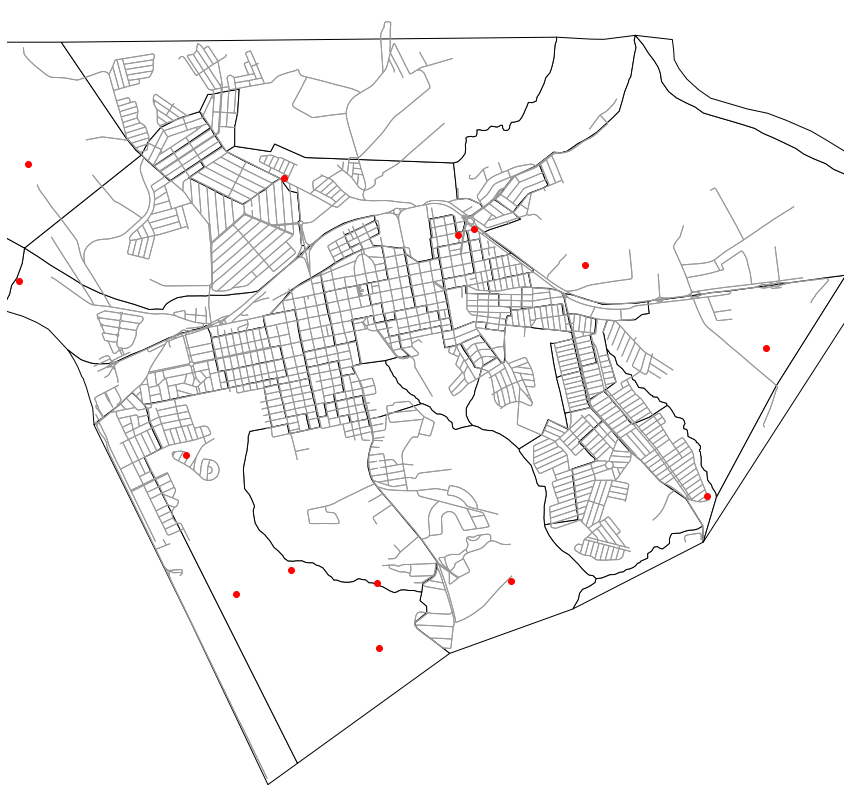

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

In [8]:
ax = tracts.plot(color='w',edgecolor='k',zorder=0,figsize=(15,15))
ax = pois.plot(color='r',zorder=3,ax=ax)
ox.plot_graph(G,ax=ax,node_size=0)

<AxesSubplot:>

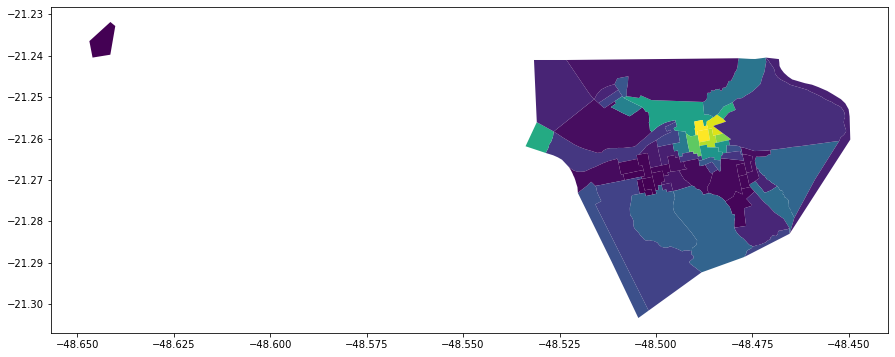

In [9]:
# calculate accessibility for each census tract
accessibility = acc.calc_tract_accessibility(tracts,pois,G,
                                             # use soft threshold as funciton
                                             func=acc.acc_soft_threshold,
                                             # set function param to 1000m walk dist:
                                             func_kws={'t':1000})
#set it as column in gdf
tracts['accessibility']=accessibility.values()
tracts.plot(column='accessibility',figsize=(15,15))

In [10]:
# calculate accessibility load for each edge on the graph
G_load = acc.calc_accessibility_load(tracts,pois,G,
                                     # use soft threshold as funciton
                                     func=acc.acc_soft_threshold,
                                     # set function param to 1000m walk dist:
                                     func_kws={'t':1000},
                                     track_progress=True)
edges = ox.graph_to_gdfs(G_load,nodes=False)

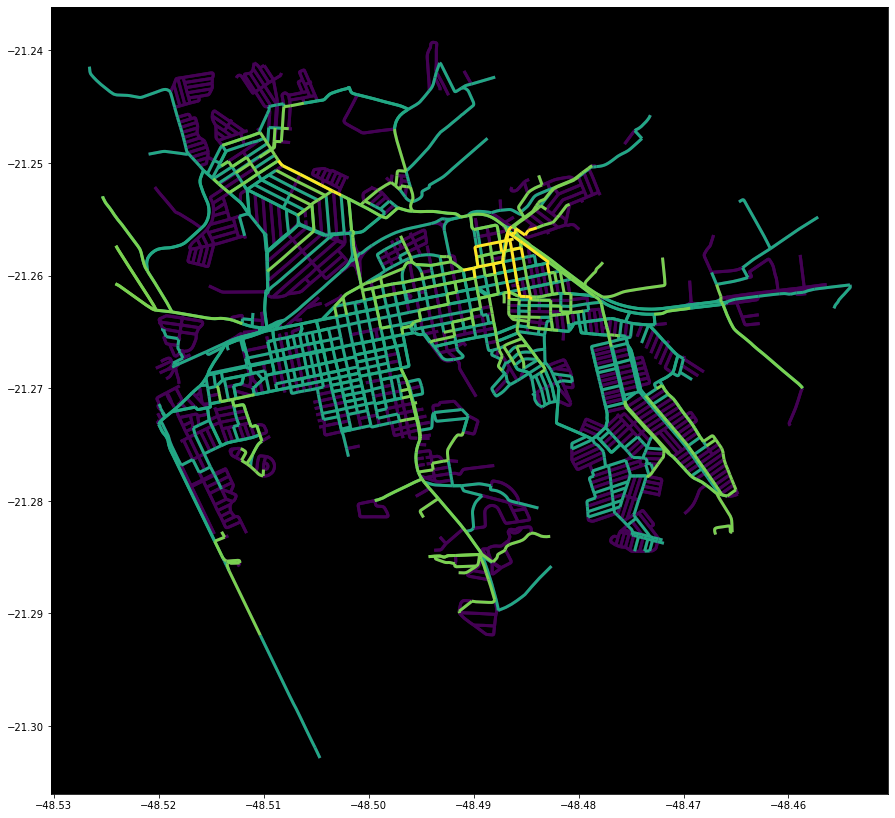

In [11]:
# plot results
edges = edges.sort_values('load')
ax=edges.plot(column='load',scheme='percentiles',#Needs mapclassify
               cmap='viridis',figsize=(15,15), linewidth=3,k=10)
ax.set_facecolor('k')